# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)

## Подготовка данных

In [1]:
# импорт библиотек

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загружу данные
try:
    df = pd.read_csv('/datasets/autos.csv')
except (IOError, EOFError) as e:
    print("Testing multiple exceptions. {}".format(e.args[-1]))

### Анализ данных

In [3]:
# функция на первичную проверку данных
def df_check(dataset):
    print('Общая информация\n')
    display(dataset.info())
    print('Первые строки датасета\n')
    display(dataset.head())
    print('Описательная статистика\n')
    display(dataset.describe())
    print('Описательная статистика категориальных признаков\n')
    display(df.describe(include=['object', 'bool']))
    print('Количество пропусков в каждом столбце\n')
    display(dataset.isna().sum())
    print('Количество уникальных значений\n')
    display(dataset.nunique())
    print('Количество дубликатов\n')
    display(dataset.duplicated().sum())    

In [4]:
df_check(df)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes:

None

Первые строки датасета



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Описательная статистика



,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Описательная статистика категориальных признаков



,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


Количество пропусков в каждом столбце



DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Количество уникальных значений



DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
NotRepaired               2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

Количество дубликатов



4

Пожалуй изучу, что скрывается в каждом столбце в качестве уникального значения.

In [5]:
def show_rows(dataset):
    for column in dataset.columns:
        print('Уникальные значения столбца', column)
        print(dataset[column].unique())

In [6]:
show_rows(df)

Уникальные значения столбца DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения столбца Price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290

Более менее картинка о данных сформировалась, небольшой итог с чем предстоит работать:

- 354365 строк и 16 столбцов
- Присутствуют пропуски в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired.
- Медианная стоимость авто 2700 евро
- В столбце RegistrationYear существуют некорректные значения года регистрации. Минимальный год регистриции автомобиля 1000, максимальный - 9999.
- Неправильно выставлены месяцы. Если первый месяц 0, то последний месяц не должен быть 12
- В столбце Power присутвует некорректное значение мощности. Макс.значение мощности автомобиля в лошадинных силах = 20 000.
- Минимальный пробег авто 5000, максимальный - 150000, но при этом много авто имееют максимальный пробег. Возможно просто ограничение ввода данных на сайте.
- Столбец NumberOfPictures с фото автомобилей. Фото нет, всего одно уникальное значение на все данные.
- 8 уникальных типов автомобильного кузова.
- Чаще встречаются авто с ручной коробкой передач.
- Чаще встречаются автомобиле на бензине.
- Самый популярный бренд автомобиль - Volkswagen.

In [7]:
# посмотрим корреляцию
corr = df.corr()

In [8]:
corr

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


<AxesSubplot:>

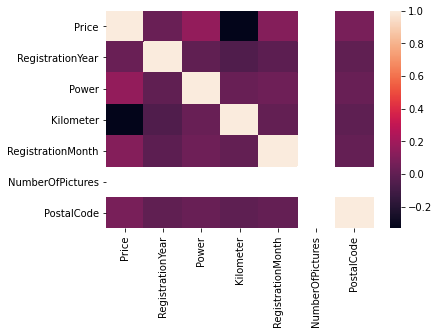

In [9]:
sns.heatmap(corr)

Интересная картина нарисовалась. Не все признаки значимы и необходимы для обучения модели. 

Значимыми столбцами буду считать:
- VehicleType. Тип машины определяет ее функционал. Чем больше возможностей у машины, тем выше цена.
- Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
- Power. Мощность в лошадиных силах (далее л.с.) напрямую влияет на цену.
- Kilometer. Имеет обратно пропорциональную зависимость от цены. Чем больше километров проехала машина, тем меньше ее надежность и соответсвенно цена.
- FuelType. Тип топлива определяет конструкцию двигателя.
- Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
- NotRepaired. У машин, которые побывали в дтп или был ремонт обычно цена всегда будет ниже, чем у подобной при других равных показателях.
- RegistrationYear. Год регистрации определяет сколько уже лет машина на ходу. Соответвенно, чем больше возраст, тем меньше цена.
- Model. Вместе с типом машины и брендом может влиять на популярность у покупателей.

Остальные столбцы для модели не требуются, так как не влияют на стоимость.

### Предобработка данных

Как было принято раньше, для работы буду использовать лишь значимые столбцы.

In [10]:
new_df = df[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]

In [11]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   NotRepaired       283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


**Количественные признаки**

**Цена**

In [12]:
# функция для вызова проверки квантилей и графика по столбцам
def check_columns(columns):
    columns.hist(bins=100, figsize=(12,10))
    display(columns.describe())

In [13]:
# проверю наполнение целевого признака Price
new_df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

10772 автомобиля отдаются бесплатно. Удалю эти значения и проверю распределение цены на гистограмме.

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

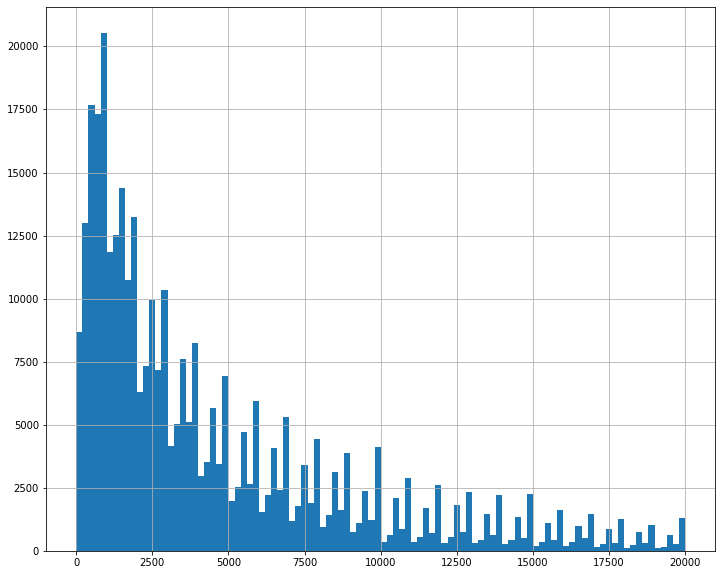

In [14]:
new_df = new_df.query('Price > 0')
check_columns(new_df['Price'])

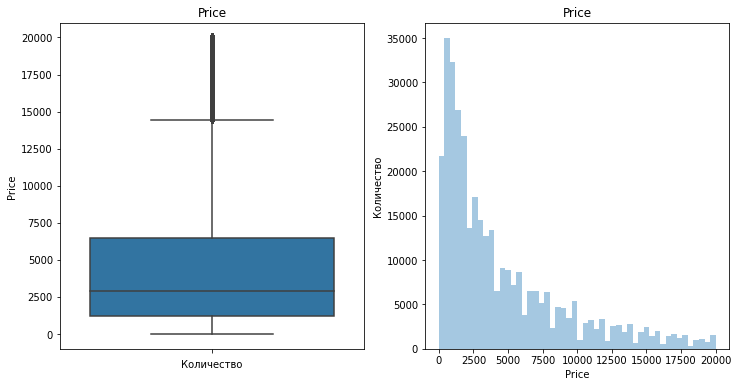

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('Price')
sns.boxplot(y = 'Price', data=new_df, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('Price')
sns.distplot(new_df['Price'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')
            
plt.show()

In [16]:
new_df = new_df.query('350 <= Price <= 14450')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309121 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       280516 non-null  object
 1   Gearbox           295030 non-null  object
 2   Power             309121 non-null  int64 
 3   Kilometer         309121 non-null  int64 
 4   FuelType          284472 non-null  object
 5   Brand             309121 non-null  object
 6   NotRepaired       251821 non-null  object
 7   RegistrationYear  309121 non-null  int64 
 8   Model             294101 non-null  object
 9   Price             309121 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 25.9+ MB


**Мощность**

count    309121.000000
mean        109.468910
std         188.996258
min           0.000000
25%          71.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

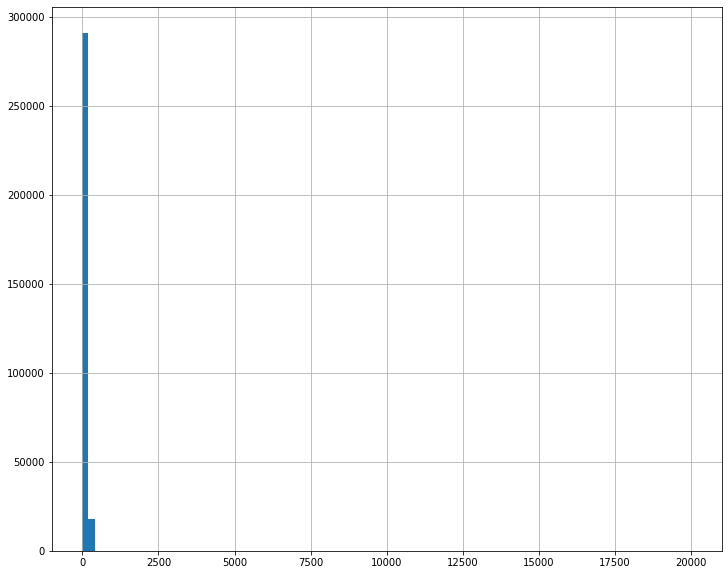

In [17]:
check_columns(new_df['Power'])

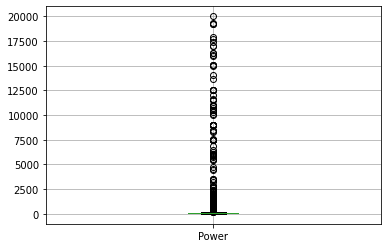

In [18]:
new_df.boxplot(column='Power')
plt.show()

Слишком много выбросов. График неинформативный, отсеку пока выбросы свыше 1000 лс.

count    308858.000000
mean        106.032941
std          59.947762
min           0.000000
25%          71.000000
50%         104.000000
75%         140.000000
max        1000.000000
Name: Power, dtype: float64

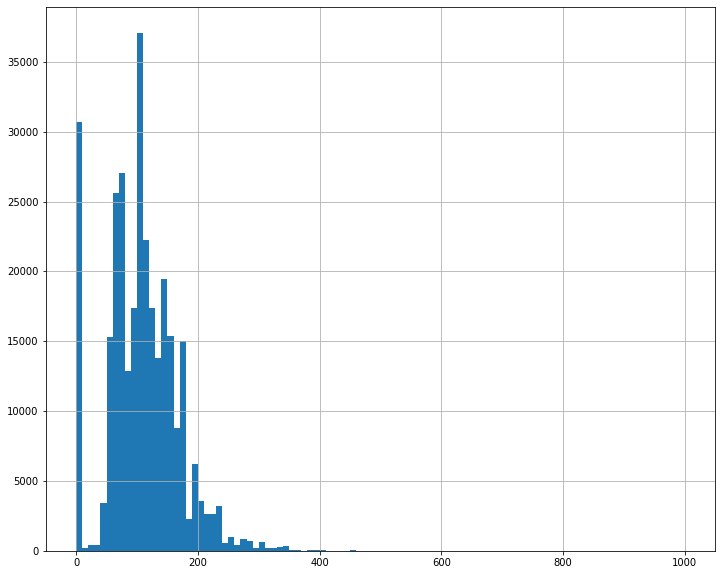

In [19]:
new_df = new_df.query('Power < 1001')
check_columns(new_df['Power'])

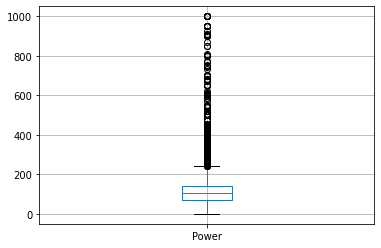

In [20]:
new_df.boxplot(column='Power')
plt.show()

Как видно из графика, в основном встречаются авто с мощностью до 250 лс. Избавлюсь от выбросов согласно с распространенным методом для точечных выбросов с BoxPlots, который писал выше. В моём случае это будет нижней точкой - 28, а верхней 247, но решил округлить до 250.</div>

count    272923.000000
mean        114.685845
std          43.922631
min          28.000000
25%          75.000000
50%         109.000000
75%         143.000000
max         250.000000
Name: Power, dtype: float64

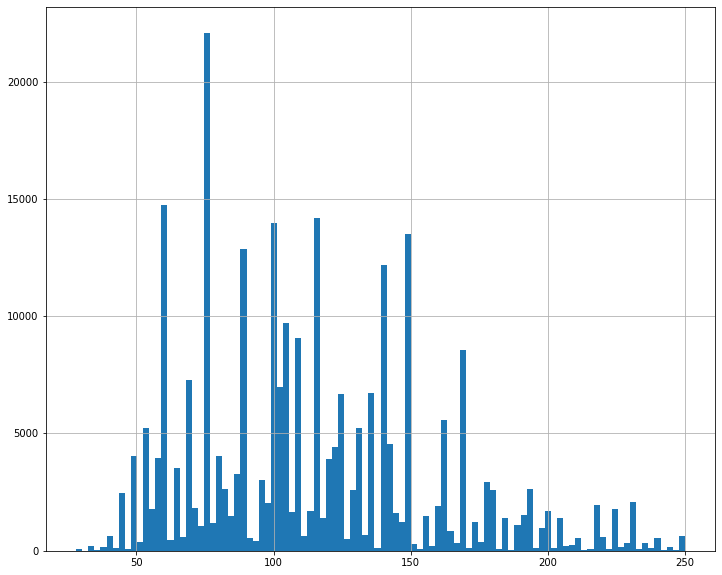

In [21]:
new_df = new_df.query('27 < Power <= 250')
check_columns(new_df['Power'])

**Год регистрации**

count    272923.000000
mean       2003.310868
std          28.566918
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

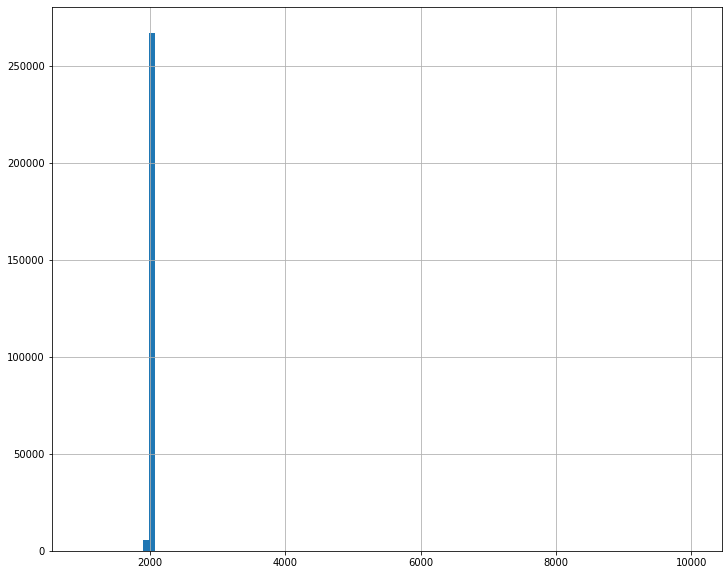

In [22]:
check_columns(new_df['RegistrationYear'])

Слишком много выбросов для года регистрации. Проверю когда была скачена последняя анкета автомобиля.

In [23]:
date = pd.to_datetime(df['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Даты регистрации после 2016 года брать не буду, они в данном случае некорректны, ну и машин раньше 1900 года не было. Отсеку не нужное для модели.

count    263275.000000
mean       2002.633801
std           6.176413
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

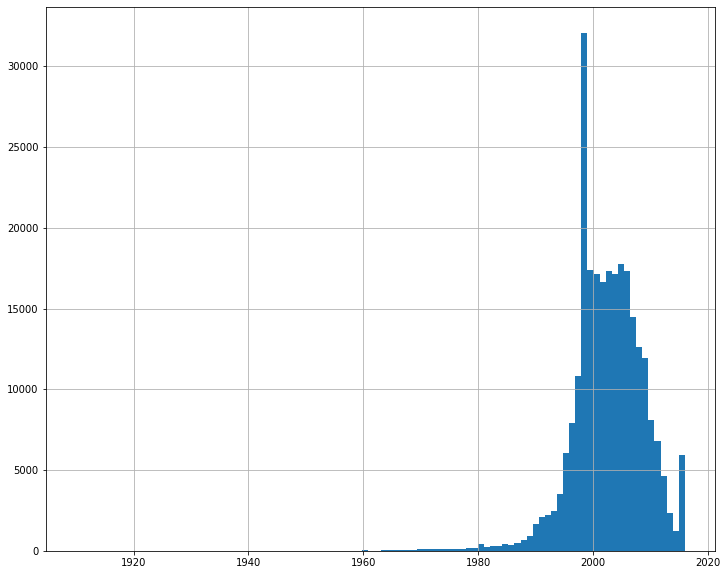

In [24]:
new_df = new_df.query('1899 < RegistrationYear < 2017')
check_columns(new_df['RegistrationYear'])

Так самый ранний год 1910, но по левой части гистограммы видно, что адекватно использовать левую границу в 1960 год, так как это старые, но возможно еще работающие машины.

count    263191.000000
mean       2002.650649
std           6.100926
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

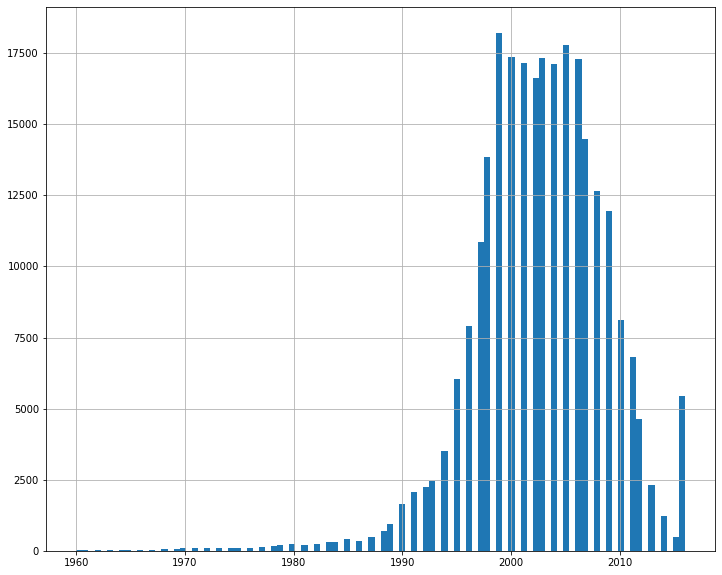

In [25]:
new_df = new_df.query('1959 < RegistrationYear < 2017')
check_columns(new_df['RegistrationYear'])

**Километраж**

count    263191.000000
mean     130361.220558
std       34750.411899
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

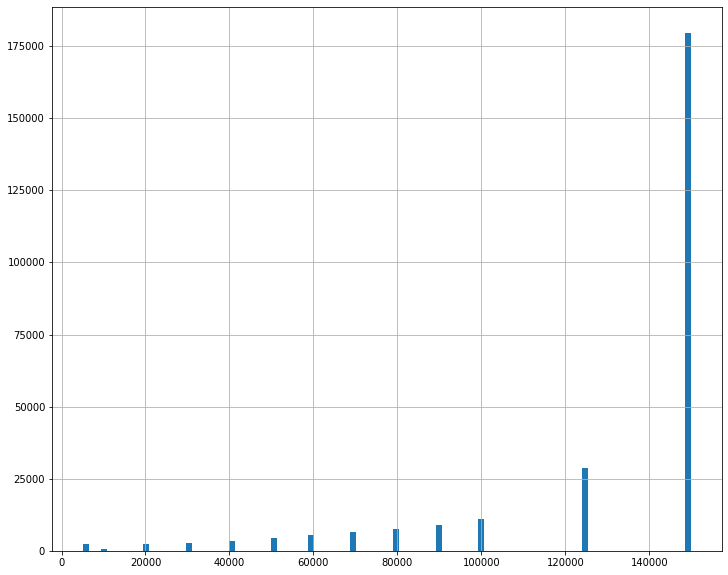

In [26]:
check_columns(new_df['Kilometer'])

Пропусков нет, уникальных значений всего 13, больше всего по максимальному значению, возможно на сайте это предел, а у пользователей был километраж и 150000+, но ставили просто максимум сайта, в любом случае значения эти трогать не буду.

In [27]:
# функция для построения графика зависимости цены от некоторых показателей

def make_price_plot(feature, title):
    mean_price = new_df[[feature, 'Price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(12,6))
    plt.grid(axis = 'both')
    sns.lineplot(x=feature, y='Price', data=mean_price)
    plt.xlabel(feature, size=12)
    plt.ylabel('Средняя цена в евро', size=12)
    plt.title(title, size=15, y=1.02)
    plt.show()

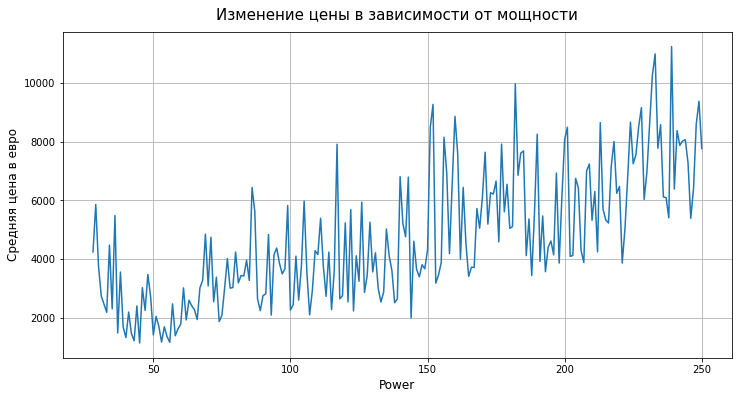

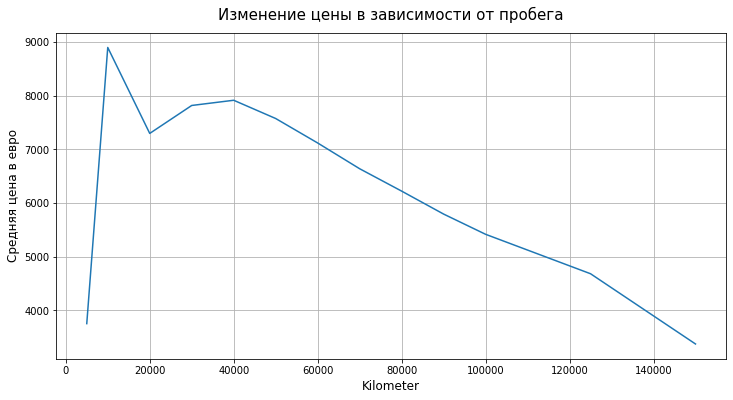

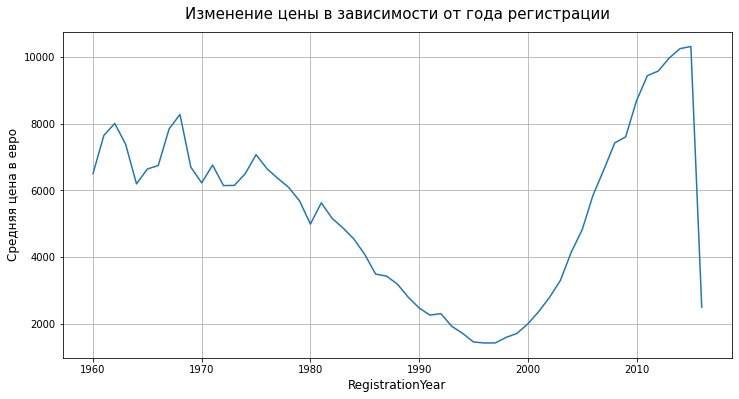

In [28]:
make_price_plot('Power', 'Изменение цены в зависимости от мощности')
make_price_plot('Kilometer', 'Изменение цены в зависимости от пробега')
make_price_plot('RegistrationYear', 'Изменение цены в зависимости от года регистрации')

**Категориальные признаки**

<AxesSubplot:>

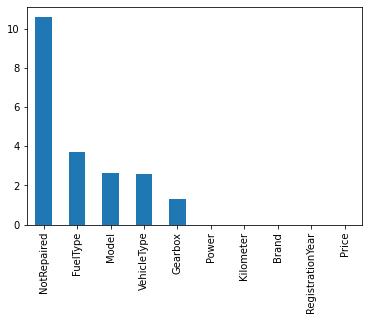

In [29]:
(new_df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100).plot(kind='bar')

Объем пропущенных значений составляют:

- 10% в столбце NotRepaired. Скорее всего владельцы пропустили это значение потому что авто прежде не ремонтировалось. Либо просто скрыли информацию, чтобы автомобиль не казался менее привлекательным к покупке
- Почти 4% в столбце FuelType
- Примерно 2,5% в столбцах VehicleType и Model
- 1,5% в столбце GearBox

Проведу замену пропусков в Gearbox, NotRepaired и Model.

In [30]:
new_df.fillna({'Gearbox':'manual', 'NotRepaired':'yes', 'Model':'unknown'}, inplace=True)
new_df.isna().sum()

VehicleType          9078
Gearbox                 0
Power                   0
Kilometer               0
FuelType            13183
Brand                   0
NotRepaired             0
RegistrationYear        0
Model                   0
Price                   0
dtype: int64

Оценю количество пропущенных значений относительно всех значений в столбце VehicleType

In [31]:
display(new_df['VehicleType'].value_counts())

sedan          73901
small          64423
wagon          53589
bus            24289
convertible    16135
coupe          11643
suv             7969
other           2164
Name: VehicleType, dtype: int64

In [32]:
vehicle_type_pivot_table = new_df.pivot_table(index='VehicleType', columns='Brand', values='Price', aggfunc='count')
display(vehicle_type_pivot_table)
new_df[new_df['Brand'] == 'bmw']['VehicleType'].value_counts()

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,9.0,3.0,127.0,349.0,1120.0,43.0,24.0,29.0,702.0,...,556.0,219.0,NaN,140.0,15.0,25.0,402.0,NaN,7785.0,NaN
convertible,146.0,1202.0,2473.0,9.0,196.0,87.0,NaN,1.0,16.0,431.0,...,NaN,3.0,1048.0,202.0,1.0,25.0,59.0,NaN,2421.0,61.0
coupe,202.0,903.0,2816.0,46.0,39.0,126.0,NaN,2.0,NaN,139.0,...,66.0,5.0,292.0,98.0,4.0,5.0,179.0,1.0,1209.0,63.0
other,8.0,77.0,188.0,24.0,5.0,86.0,6.0,3.0,5.0,134.0,...,44.0,17.0,4.0,47.0,4.0,9.0,14.0,NaN,580.0,4.0
sedan,788.0,8504.0,14004.0,186.0,197.0,584.0,95.0,78.0,37.0,739.0,...,1465.0,775.0,26.0,236.0,114.0,147.0,803.0,9.0,16604.0,544.0
small,211.0,1095.0,338.0,523.0,10.0,1322.0,214.0,205.0,396.0,4211.0,...,2705.0,1024.0,2961.0,77.0,93.0,832.0,1436.0,5.0,15092.0,6.0
suv,NaN,62.0,435.0,233.0,11.0,29.0,183.0,1.0,41.0,22.0,...,3.0,114.0,NaN,225.0,49.0,659.0,356.0,NaN,704.0,142.0
wagon,416.0,8837.0,6430.0,96.0,211.0,520.0,227.0,35.0,14.0,339.0,...,320.0,2292.0,9.0,90.0,246.0,74.0,493.0,8.0,10784.0,1680.0


sedan          14004
wagon           6430
coupe           2816
convertible     2473
suv              435
small            338
other            188
bus                3
Name: VehicleType, dtype: int64

Теперь создам словарь брендов и популярных типов машин и заполню пропуски по столбцу VehicleType.

In [33]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263191 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       254113 non-null  object
 1   Gearbox           263191 non-null  object
 2   Power             263191 non-null  int64 
 3   Kilometer         263191 non-null  int64 
 4   FuelType          250008 non-null  object
 5   Brand             263191 non-null  object
 6   NotRepaired       263191 non-null  object
 7   RegistrationYear  263191 non-null  int64 
 8   Model             263191 non-null  object
 9   Price             263191 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 22.1+ MB


In [34]:
new_df.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

In [35]:
new_df['VehicleType'] = new_df.apply(
                                fillna_by_brand, 
                                args=[0, vehicle_type_pivot_table],
                                axis=1)
display(new_df['VehicleType'].isna().sum())
new_df['VehicleType'].value_counts()

0

sedan          78300
small          68209
wagon          54435
bus            24313
convertible    16142
coupe          11643
suv             7985
other           2164
Name: VehicleType, dtype: int64

По такому же принципу заполню пропуски в FuelType.

In [36]:
new_df['FuelType'].value_counts()
fuel_type_pivot_table = new_df.pivot_table(index='FuelType', columns='Brand', values='Price', aggfunc='count')
display(fuel_type_pivot_table)

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,NaN,6.0,4.0,NaN,5.0,2.0,NaN,NaN,61.0,...,2.0,6.0,2.0,6.0,2.0,NaN,NaN,NaN,164.0,20.0
electric,NaN,2.0,2.0,NaN,NaN,1.0,NaN,NaN,1.0,2.0,...,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,536.0,9316.0,8788.0,172.0,309.0,1345.0,177.0,1.0,4.0,1199.0,...,1436.0,1584.0,760.0,235.0,27.0,198.0,856.0,1.0,20251.0,844.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,9.0,NaN,NaN,82.0,NaN,3.0,NaN
lpg,28.0,341.0,570.0,145.0,74.0,56.0,47.0,21.0,3.0,57.0,...,58.0,49.0,3.0,64.0,27.0,16.0,19.0,NaN,461.0,92.0
other,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,1.0,NaN,NaN,10.0,2.0
petrol,1185.0,10685.0,16698.0,908.0,608.0,2414.0,522.0,328.0,514.0,5301.0,...,3611.0,2755.0,3532.0,756.0,454.0,1534.0,2763.0,20.0,33857.0,1479.0


In [37]:
new_df.fillna({'FuelType':0},inplace=True)

new_df['FuelType'] = new_df.apply(
                                fillna_by_brand, 
                                args=[4, vehicle_type_pivot_table],
                                axis=1)
display(new_df['FuelType'].isna().sum())
new_df['FuelType'].value_counts()

0

petrol         168040
gasoline        77168
sedan            6034
small            5700
lpg              4103
wagon            1344
cng               468
hybrid            152
bus                51
other              50
suv                45
electric           27
convertible         9
Name: FuelType, dtype: int64

In [38]:
new_df.isna().sum()

VehicleType         0
Gearbox             0
Power               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
RegistrationYear    0
Model               0
Price               0
dtype: int64

Пропуски убраны. Теперь удалю дубликаты.

In [39]:
good_df = new_df.drop_duplicates().reset_index(drop=True)

Проведу замену столбцов Gearbox и NotRepaired на булев тип.

- IsManualGearbox. 1(manual) - означает механическую коробку передач. 0(auto) - автоматическую.
- IsNotRepaired. 1(yes) - означает машину без ремонта. 0(no) - с ремонтом.

In [40]:
good_df['IsManualGearbox'] = 0
good_df.loc[good_df['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(good_df['IsManualGearbox'].value_counts())
good_df['Gearbox'].value_counts()

1    184233
0     41148
Name: IsManualGearbox, dtype: int64

manual    184233
auto       41148
Name: Gearbox, dtype: int64

In [41]:
good_df['IsNotRepaired'] = 0
good_df.loc[good_df['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1
display(good_df['IsNotRepaired'].value_counts())
good_df['NotRepaired'].value_counts()

0    169506
1     55875
Name: IsNotRepaired, dtype: int64

no     169506
yes     55875
Name: NotRepaired, dtype: int64

Удалю ненужные столбцы и уменьшу размерность хранения типа для ускорения работы с дата фреймом.

In [42]:
good_df.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)
good_df['IsNotRepaired'] = pd.to_numeric(good_df['IsNotRepaired'], downcast='integer')
good_df['IsManualGearbox'] = pd.to_numeric(good_df['IsManualGearbox'], downcast='integer')
good_df['RegistrationYear'] = pd.to_numeric(good_df['RegistrationYear'], downcast='integer')
good_df['Power'] = pd.to_numeric(good_df['Power'], downcast='integer')
good_df['Kilometer'] = pd.to_numeric(good_df['Kilometer'], downcast='integer')
good_df['Price'] = pd.to_numeric(good_df['Price'], downcast='integer')
good_df.info()
display(good_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225381 entries, 0 to 225380
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       225381 non-null  object
 1   Power             225381 non-null  int16 
 2   Kilometer         225381 non-null  int32 
 3   FuelType          225381 non-null  object
 4   Brand             225381 non-null  object
 5   RegistrationYear  225381 non-null  int16 
 6   Model             225381 non-null  object
 7   Price             225381 non-null  int16 
 8   IsManualGearbox   225381 non-null  int8  
 9   IsNotRepaired     225381 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 9.5+ MB


(225381, 10)

In [43]:
print('Уменьшение использования памяти на {:.2%}'.format(1 - 9.5/43.3))

Уменьшение использования памяти на 78.06%


### Вывод

- В данных было много пропущенных значений и выбросов.
- Они успешно были удалены и/или заменены на корректные данные.
- Отобраны небходимые столбцы для обучения модели.
- Заменены два категориальных признака на численные.
- Выигрыш в памяти составляет 78%, что ускорит обращение к памяти при обучении модели.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Детальный анализ провели и  подготовили данные. Переходим к обучению моделей.

## Обучение моделей

Для обучения моделей буду использовать следующее:
- LinearRegression
- Ridge
- DecisionTreeRegressor
- CatBoostRegressor
- LGBMRegressor

В качестве метрики для всех моделей буду использовать MSE и в финальной таблице переведу в RMSE. Качество моделей буду проверять на кроссвалидации.

Подготовлю три типа признаков для кроссвалидации:

- Неизмененные. Название original_features.
- Закодированные методом OHE. Название ohe_features.
- Закодированные методом OE. Название ordinal_features.

In [44]:
# неизмененные признаки
original_features = good_df.drop('Price', axis=1)

In [45]:
# прямое кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

In [46]:
# OHE кодирование
ohe_features = pd.get_dummies(original_features, drop_first=True)

In [47]:
# целевой признак
target = good_df['Price']

In [48]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=12345)

ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

### Линейная регрессия

In [49]:
start = time.time()

regressor_lr = LinearRegression()
print('# Обучение для neg_root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor_lr, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_root_mean_squared_error').mean() * -1)
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)
end = time.time()
regressor_lr_time_train = end - start
print('Время обучения модели:', regressor_lr_time_train)

# Обучение для neg_root_mean_squared_error

Mean RMSE from CV of LinearRegression = 2103.000710584877
Время обучения модели: 94.35590124130249


Проведу масштабирование признаков

In [50]:
start = time.time()

regressor_lr_m = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor_lr_m)])
print('# Обучение для neg_root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_root_mean_squared_error').mean() * -1)
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

end = time.time()
regressor_lr_m_time_train = end - start
print('Время обучения модели:', regressor_lr_m_time_train)

# Обучение для neg_root_mean_squared_error

Mean RMSE from CV of LinearRegression = 2338128844554.1084
Время обучения модели: 96.81733918190002


Масштабирование только ухудшает модель - откажусь от масштабирования.

In [51]:
start = time.time()
regressor_lr.fit(ohe_features_train, target_train)
lr_predict = regressor_lr.predict(ohe_features_train)
end = time.time()
lr_predict_time = end - start
print('Время предсказания модели:', lr_predict_time)

Время предсказания модели: 20.592490434646606


### Регрессия Ridge

In [52]:
#%%time

#regressor = Ridge()
#hyperparams = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]


#print('# Tuning hyper-parameters for root_mean_squared_error')
#print()
#clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
#clf.fit(ohe_features_train, target_train)
#print("Best parameters set found on development set:")
#print()
#print(clf.best_params_)
#print()
#print("Grid scores on development set:")
#print()
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #print("%0.6f for %r"% ((mean*-1)** 0.5, params))
#print()

#cv_RMSE_R = (max(means)*-1) ** 0.5

У меня после изменений с выбросами в Price почему-то начал подыхать kernell на Регрессии Ridge. Убрал её пока из работы.

### Регрессия DecisionTreeRegressor

Проведу два эксперимента:

1. Проверю модель на признаках, закодированных по методу OHE.
2. На признаках, закодированных по методу OE.

In [53]:
#%%time

#regressor_dtr_ohe = DecisionTreeRegressor(criterion='mse',  
                #random_state=12345) 
#max_depth_list = [x for x in range(2, 31)]
#hyperparams = [{'max_depth':max_depth_list}]

#print('# Tuning hyper-parameters for root_mean_squared_error')
#print()
#clf = GridSearchCV(regressor_dtr_ohe, hyperparams, scoring='neg_mean_squared_error')
#clf.fit(ohe_features_train, target_train)
#print("Best parameters set found on development set:")
#print()
#print(clf.best_params_)
#print()
#print("Grid scores on development set:")
#print()
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #print("%0.6f for %r"% ((mean*-1)** 0.5, params))
#print()

#cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

In [54]:
start = time.time()

regressor_dtr = DecisionTreeRegressor(criterion='mse', random_state=12345) 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'max_depth':max_depth_list}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor_dtr, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

end = time.time()
regressor_dtr_time_train = end - start
print('Время обучения модели:', regressor_dtr_time_train) 

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'max_depth': 14}

Grid scores on development set:

2527.999839 for {'max_depth': 2}
2324.132312 for {'max_depth': 3}
2079.472500 for {'max_depth': 4}
1962.538018 for {'max_depth': 5}
1866.818415 for {'max_depth': 6}
1789.199928 for {'max_depth': 7}
1723.993724 for {'max_depth': 8}
1674.807630 for {'max_depth': 9}
1635.718316 for {'max_depth': 10}
1607.106794 for {'max_depth': 11}
1589.525045 for {'max_depth': 12}
1583.283654 for {'max_depth': 13}
1583.123157 for {'max_depth': 14}
1591.311352 for {'max_depth': 15}
1610.802884 for {'max_depth': 16}
1624.971136 for {'max_depth': 17}
1643.505659 for {'max_depth': 18}
1653.440417 for {'max_depth': 19}
1668.293700 for {'max_depth': 20}
1676.825771 for {'max_depth': 21}
1685.792192 for {'max_depth': 22}
1688.628919 for {'max_depth': 23}
1696.863156 for {'max_depth': 24}
1698.949658 for {'max_depth': 25}
1697.359873 for {'max_depth': 26}
1699

In [55]:
start = time.time()

regressor_dtr_predict = clf.predict(ordinal_features_train)
end = time.time()
regressor_dtr_time_predict = end - start
print('Время предсказания модели:', regressor_dtr_time_predict)


Время предсказания модели: 0.03471779823303223


Обучение на OHE данных дало почти похожий результат, что и порядковое кодирование признаков. Т.к. в принципе на "деревянной" модели принято обучать на признаках с OE-кодирование, то его только и оставлю.

### Регрессия CatBoostRegressor

Здесь так же проведу два эксперимента:

1. Обучу модель на данных, закодированных по методу OE.
2. Обучу на оригинальных данных с указанием категорий.

In [56]:
start = time.time()

regressor_cbr = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor_cbr, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

end = time.time()
regressor_cbr_time_train = end - start

print('Время обучения модели:', regressor_cbr_time_train) 

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

Grid scores on development set:

1340.231217 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
1327.359190 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
1357.393204 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

Время обучения модели: 298.8622844219208


In [57]:
start = time.time()

regressor_cbr_predict = clf.predict(ordinal_features_train)
end = time.time()
regressor_cbr_time_predict = end - start
print('Время предсказания модели:', regressor_cbr_time_predict)


Время предсказания модели: 0.16052627563476562


In [58]:
start = time.time()

regressor_cbr_original = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=12345, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor_cbr_original,
                                original_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

end = time.time()
regressor_cbr_original_time_train = end - start
print('Время обучения модели:', regressor_cbr_original_time_train)


# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 1352.793441228656
Время обучения модели: 98.23817658424377


In [59]:
start = time.time()
regressor_cbr_original.fit(original_features_train, target_train)
regressor_cbr_original_predict = regressor_cbr_original.predict(original_features_train)

end = time.time()
regressor_cbr_original_time_predict = end - start
print('Время предсказания модели:', regressor_cbr_original_time_predict)


Время предсказания модели: 24.519901990890503


### Регрессия LGBMRegressor

In [60]:
start = time.time()

regressor_lgbm = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor_lgbm, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

end = time.time()
regressor_lgbm_time_train = end - start
print('Время обучения модели:', regressor_lgbm_time_train)


# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}

Grid scores on development set:

1401.737050 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
1345.474095 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
1327.097291 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}
1360.724244 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 12345}
1333.778507 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 12345}
1330.347901 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}
1363.916869 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 12345}
1354.640751 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 12345}
1363.521991 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 12345}

Время обучения модели: 318.79657196998596


In [62]:
start = time.time()

regressor_lgbm_predict = clf.predict(ordinal_features_train)

end = time.time()
regressor_lgbm_time_predict = end - start
print('Время предсказания модели:', regressor_lgbm_time_predict)



Время предсказания модели: 1.878075361251831


### Вывод

Провёл обучение моделей, лучшие гиперпараметры и время их выполнения занесу в таблицу. 

## Анализ моделей

Теперь для анализа всех моделей сведу все полученные данные о моделях в одну таблицу.

In [63]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_DTR_ordinal,
                            cv_RMSE_CBR_ordinal,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[regressor_lr_time_train,
                                     regressor_dtr_time_train,
                                     regressor_cbr_time_train,
                                     regressor_cbr_original_time_train,
                                     regressor_lgbm_time_train],
        'Время предсказания модели, сек':[lr_predict_time,
                                          regressor_dtr_time_predict,
                                          regressor_cbr_time_predict,
                                          regressor_cbr_original_time_predict,
                                          regressor_lgbm_time_predict]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Общее время, сек'] = (scores_data['Время обучения на CV, сек'] + 
                                               scores_data['Время предсказания модели, сек'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","Время предсказания модели, сек","Общее время, сек"
LinearRegression,2103.000711,94.355901,20.592490,114.948392
DecisionTreeRegressor on OE features,1583.123157,47.230485,0.034718,47.265203
CatBoostRegressor on OE features,1327.359190,298.862284,0.160526,299.022811
CatBoostRegressor on original features,1352.793441,98.238177,24.519902,122.758079
LGBMRegressor,1327.097291,318.796572,1.878075,320.674647


Исходя из такой таблицы можно сделать вывод, что лучшие показатели (соотношение затраченного времени на обучение и предсказание) и RMSE у CatBoostRegressor. Причём на "сырых" данных работает значительно быстрее в плане обучения, но не предсказания.

Хотя точность лучше у LGBMRegressor, но при этом CatBoostRegressor на кодированных признаках показывает почти такую же точность.

Лучшая модель всё же CatBoostRegressor on original features протестирую её на тестовой выборке.

### Регрессия CatBoostRegressor

In [64]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

CPU times: user 23.8 s, sys: 259 ms, total: 24.1 s
Wall time: 24.4 s


In [66]:
target_predict = model.predict(original_features_test)

In [67]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_CBR_original

1339.6915940310996

Построю график важности для лучшей выбранной модели

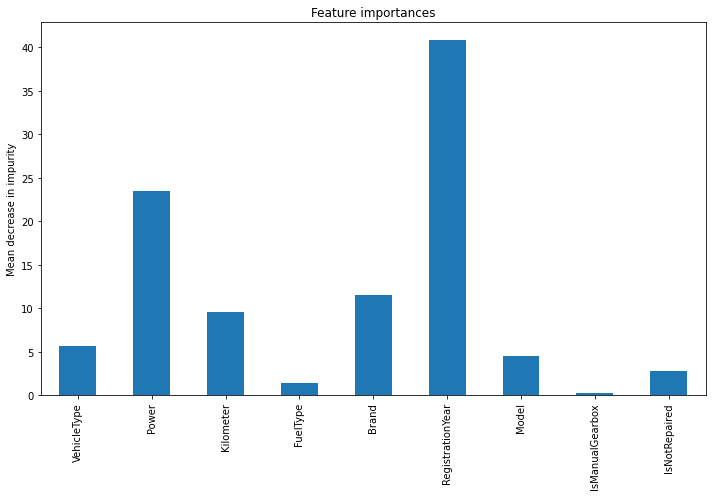

In [74]:
feature_names = original_features_train.columns 
model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model'])
model.fit(original_features_train, target_train)
pred = model.predict(original_features_test)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

График важности модели соответствует тому, что было проанализировано в самом начале на исходных данных.

## Итоговый вывод

В ходе работы было выполнено:

- Загружены данные. Проведен анализ и предобработка.
- Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
- Выбрана лучшая модель по результатам метрики RMSE и времени обучения и это CatBoostRegressor.
